In [1]:
import emcee
import numpy as np
import pyimfit
import pathlib
import cProfile
import time
import pickle
import matplotlib.pyplot as plt
from astropy.io import fits
import tqdm
from multiprocessing import Pool
import corner

plt.rcParams['image.cmap'] = 'Blues'

imageFile = "agn.fits"
imageAGN = fits.getdata(imageFile)

epsf = fits.getdata("../psfConstruction/epsf2.fits")
epsf_star = fits.getdata("../psfConstruction/star0.fits")

In [2]:
def getFits():
    """get fitters and best fit values"""
    with open('fitResults/J1215+1344_fit_.pkl', 'rb') as file:
        d = pickle.load(file)
    # get model to create fitters
    models_n1 = d['fitConfig_n1']
    models_n4 = d['fitConfig_n4']
    psfOsamp = pyimfit.MakePsfOversampler(epsf, 4, (0,100,0,100))
    osampleList = [psfOsamp]
    fitters_n1, fitters_n4 =[], []
    for fitters, models in zip([fitters_n1, fitters_n4],[models_n1,models_n4]):
        for i in tqdm.tqdm(range(len(models)), desc="Fitting Models"):
            imfit_fitter = pyimfit.Imfit(models[i],psf=epsf)
            imfit_fitter.loadData(imageAGN, psf_oversampling_list=osampleList, gain=9.942e-1, read_noise=0.22, original_sky=15.683)
            fitters.append(imfit_fitter)
    return fitters_n1, fitters_n4, d['bestfit_n1'], d['bestfit_n4']

fitters_n1, fitters_n4, bestfits_n1, bestfits_n4 = getFits()

PsfOversampling: starting initialization...
141
PsfOversampling: done.


Fitting Models: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 16.25it/s]

PsfOversampling: starting __dealloc__.
PsfOversampling: done with __dealloc__.


In [4]:
m= 3
n =0
for i,j in zip(fitters_n1[m].numberedParameterNames, fitters_n1[m].getParameterLimits()):
    print(n, i,j)
    n+=1


0 X0_1 (0.0, 100.0)
1 Y0_1 (0.0, 100.0)
2 I_tot_1 None
3 X0_2 (0.0, 100.0)
4 Y0_2 (0.0, 100.0)
5 I_tot_2 None
6 X0_3 (0.0, 100.0)
7 Y0_3 (0.0, 100.0)
8 PA_3 (0.0, 360.0)
9 ell_bulge_3 (0.0, 1.0)
10 n_3 None
11 I_e_3 (0.0, 135.13360595703125)
12 r_e_3 (0.0, 100.0)
13 X0_4 (0.0, 100.0)
14 Y0_4 (0.0, 100.0)
15 PA_4 (0.0, 360.0)
16 ell_bulge_4 (0.0, 1.0)
17 n_4 None
18 I_e_4 (0.0, 135.13360595703125)
19 r_e_4 (0.0, 100.0)


In [90]:
m=1
parameterLimits = fitters_n1[m].getParameterLimits()
names = fitters_n1[m].numberedParameterNames
rmind = [i for i, name in zip(range(len(names)),names) if "n_" in name]
parameterLimits = [element for indx, element in enumerate(parameterLimits) if indx not in rmind]
parameterLimits = [(0,100000) if e is None else e for e in parameterLimits]
parameterLimits

[(0.0, 100.0),
 (0.0, 100.0),
 (0, 100000),
 (0.0, 360.0),
 (0.0, 1.0),
 (0.0, 135.13360595703125),
 (0.0, 100.0),
 (0.0, 100.0),
 (0.0, 100.0),
 (0, 100000),
 (0.0, 360.0),
 (0.0, 1.0),
 (0.0, 135.13360595703125),
 (0.0, 100.0)]

In [3]:
def get_rm_inds(fitter):
    names = fitter.numberedParameterNames
    rm_inds = [i for i, name in zip(range(len(names)),names) if "n_" in name]
    return rm_inds

rm_inds = [get_rm_inds(fitter) for fitter in fitters_n1]
rm_inds

[[5], [5, 13], [7], [10, 17]]

# check prior

In [5]:

def lnPrior_func(params,imfitter,rmind):
    parameterLimits = imfitter.getParameterLimits()
    parameterLimits = [element for indx, element in enumerate(parameterLimits) if indx not in rmind]
    parameterLimits = [(0,100000) if e is None else e for e in parameterLimits]
    nParams = len(params)
    for i in range(nParams):
        if params[i] < parameterLimits[i][0] or params[i] > parameterLimits[i][1]:
            return  -np.inf
    return 0.0

m = 1
p_bestfit = bestfits_n1[m]
p_bestfit = np.delete(p_bestfit, rm_inds[m])
ndims, nwalkers = len(p_bestfit), 50
initial_pos = [p_bestfit + 0.001*np.random.randn(ndims) for i in range(nwalkers)]

for i in range(20):
    print(i, lnPrior_func(initial_pos[i],fitters_n1[m],rm_inds[m]) )


0 -inf
1 -inf
2 -inf
3 -inf
4 -inf
5 0.0
6 0.0
7 0.0
8 0.0
9 -inf
10 0.0
11 -inf
12 0.0
13 -inf
14 0.0
15 0.0
16 0.0
17 -inf
18 0.0
19 0.0


# check posterior

In [8]:
def lnPosterior_func_chi(params, imfitter, p_bestfit, rmind):
    lnPrior = lnPrior_func(params,imfitter,rmind)
    if not np.isfinite(lnPrior):
        return -np.inf
    params = np.insert(p_bestfit,rmind,1)
    #compute chi square likelihood
    newIm = imfitter.getModelImage(newParameters=params)
    chisquared = np.sum(((newIm - imageAGN)**2) / (imageAGN*0.01)**2)
    lnLikelihood = -0.5*chisquared
    return lnPrior + lnLikelihood

def lnPosterior_pf(params, imfitter, lnPrior_func, rmInd):
    lnPrior = lnPrior_func(params, imfitter, rmInd)
    if not np.isfinite(lnPrior):
        return -np.inf
    params = np.insert(params,rmInd,1)
    
    lnLikelihood = -0.5 * imfitter.computeFitStatistic(params)
    return lnPrior + lnLikelihood

m=0
p_bestfit = bestfits_n1[m]
p_bestfit = np.delete(p_bestfit, rm_inds[m])
ndims, nwalkers = len(p_bestfit), 50
initial_pos = [p_bestfit + 0.001*np.random.randn(ndims) for i in range(nwalkers)]
for i in range(20):
    print(i, lnPrior_func(initial_pos[i],fitters_n1[m],rm_inds[m]), lnPosterior_pf(initial_pos[i],fitters_n1[m],lnPrior_func,rm_inds[m]) )

0 0.0 -819.5707038501538
1 0.0 -819.5764248867658
2 0.0 -819.5688645613642
3 0.0 -819.6003731011039
4 0.0 -819.5695552695412
5 0.0 -819.5806733024599
6 0.0 -819.5688961148783
7 0.0 -819.59578301359
8 0.0 -819.5688344902694
9 0.0 -819.5739284203546
10 0.0 -819.5691148180556
11 0.0 -819.580886333625
12 0.0 -819.5697280492577
13 0.0 -819.5697288078247
14 0.0 -819.598741568839
15 0.0 -819.570181598666
16 0.0 -819.5715642742961
17 0.0 -819.5771521301518
18 0.0 -819.574235642621
19 0.0 -819.5720069518466


In [9]:
def run_emcee(p_bestfit, fitter,rmInd,numsteps):
    p_bestfit = np.delete(p_bestfit, rmInd)
    ndims, nwalkers = len(p_bestfit), 50
    initial_pos = [p_bestfit + 0.001*np.random.randn(ndims) for i in range(nwalkers)]
    #for i in range(20):
   #     print(i,lnPrior_func(initial_pos[i],fitter ,rmInd))
      #  print(i, lnPosterior_pf(initial_pos[i],fitter,lnPrior_func,rmInd) )
    sampler = emcee.EnsembleSampler(nwalkers, ndims, lnPosterior_pf, args=(fitter, lnPrior_func, rmInd))
    sampler.reset()
    final_state = sampler.run_mcmc(initial_pos,numsteps,progress=True)
    return sampler

In [14]:
#sampler = run_emcee(bestfits_n1[1], fitters_n1[1] ,rm_inds[1],numsteps=500)

c = [5.33994243e+01, 5.34870573e+01 ,4.32690713e+04, 3.54477783e+02,
 2.22902578e-04 ,1.40349197e+00, 2.08119743e+01 ,4.83943649e+01,
 5.76560658e+01 ,3.80936812e+04 ,7.43088756e+01 ,3.84438298e-01,
 1.54907841e+01 ,1.08693851e+01]

np.insert(c,[5,13],1)

array([5.33994243e+01, 5.34870573e+01, 4.32690713e+04, 3.54477783e+02,
       2.22902578e-04, 1.00000000e+00, 1.40349197e+00, 2.08119743e+01,
       4.83943649e+01, 5.76560658e+01, 3.80936812e+04, 7.43088756e+01,
       3.84438298e-01, 1.54907841e+01, 1.00000000e+00, 1.08693851e+01])

In [142]:
l=['X0_1',
 'Y0_1',
 'I_tot_1',
 'PA_2',
 'ell_bulge_2',
 'I_e_2',
 'r_e_2',
 'X0_2',
 'Y0_2',
 'I_tot_3',
 'PA_4',
 'ell_bulge_4',
 'I_e_4',
 'r_e_4']

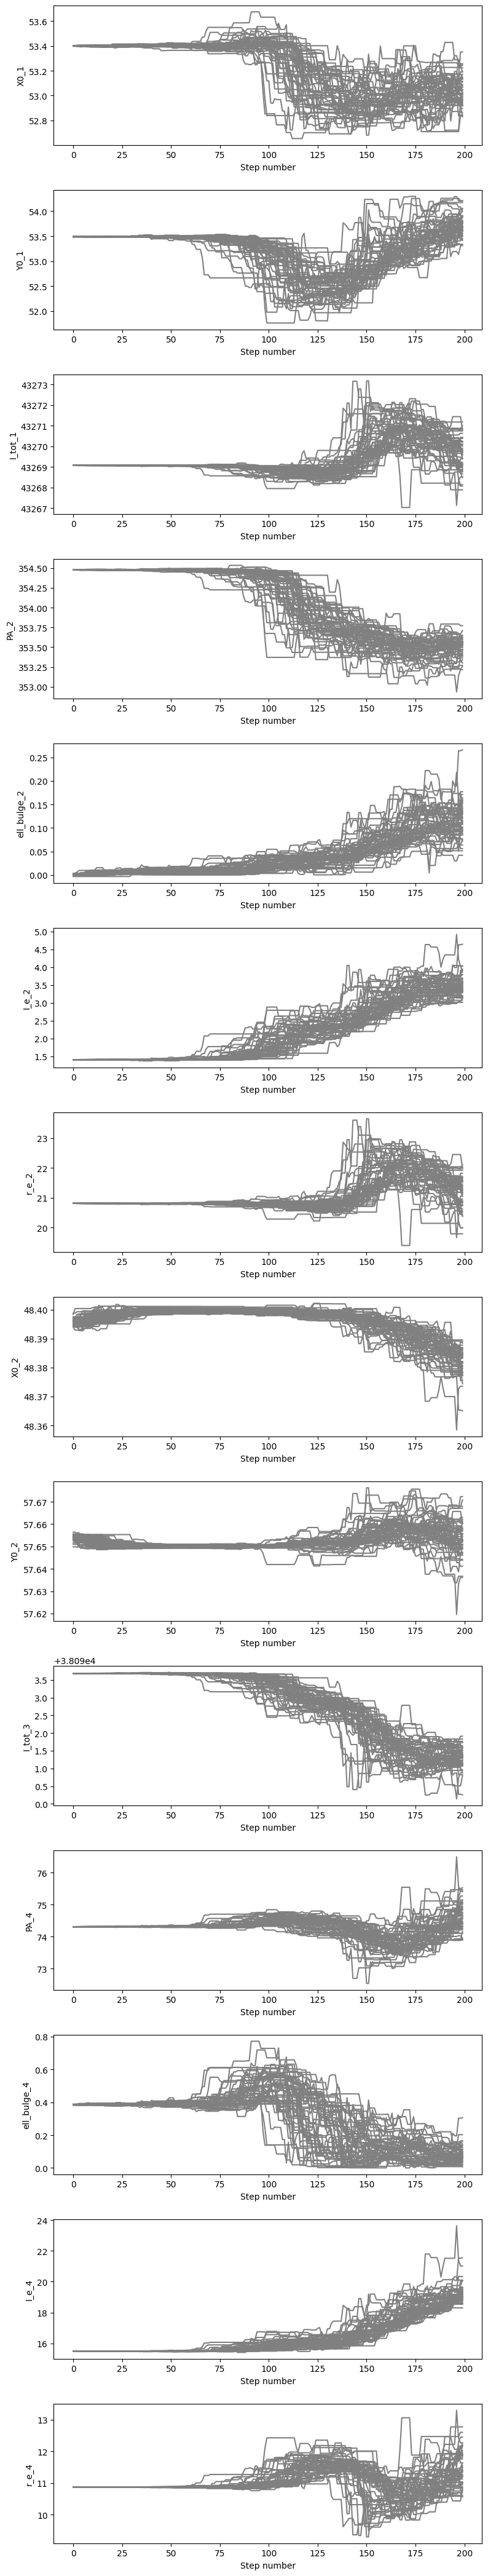

In [143]:
def PlotAllWalkers(sample_chain, yAxisLabel, figtitle):
    n = len(yAxisLabel)
    fig,ax = plt.subplots(n,1,figsize=(8, n*3))
    nWalkers = sample_chain.shape[0]
    for j in range(len(yAxisLabel)):
        for i in range(nWalkers):
            ax[j].plot(sample_chain[i,:,j], color='0.5')
    [ax[i].set_xlabel('Step number') for i in range(len(yAxisLabel))]
    [ax[i].set_ylabel(yAxisLabel[i]) for i in range(len(yAxisLabel))]
    ax[0].set_title(figtitle)
    
    fig.tight_layout();
 

PlotAllWalkers(sampler.chain, l, "")


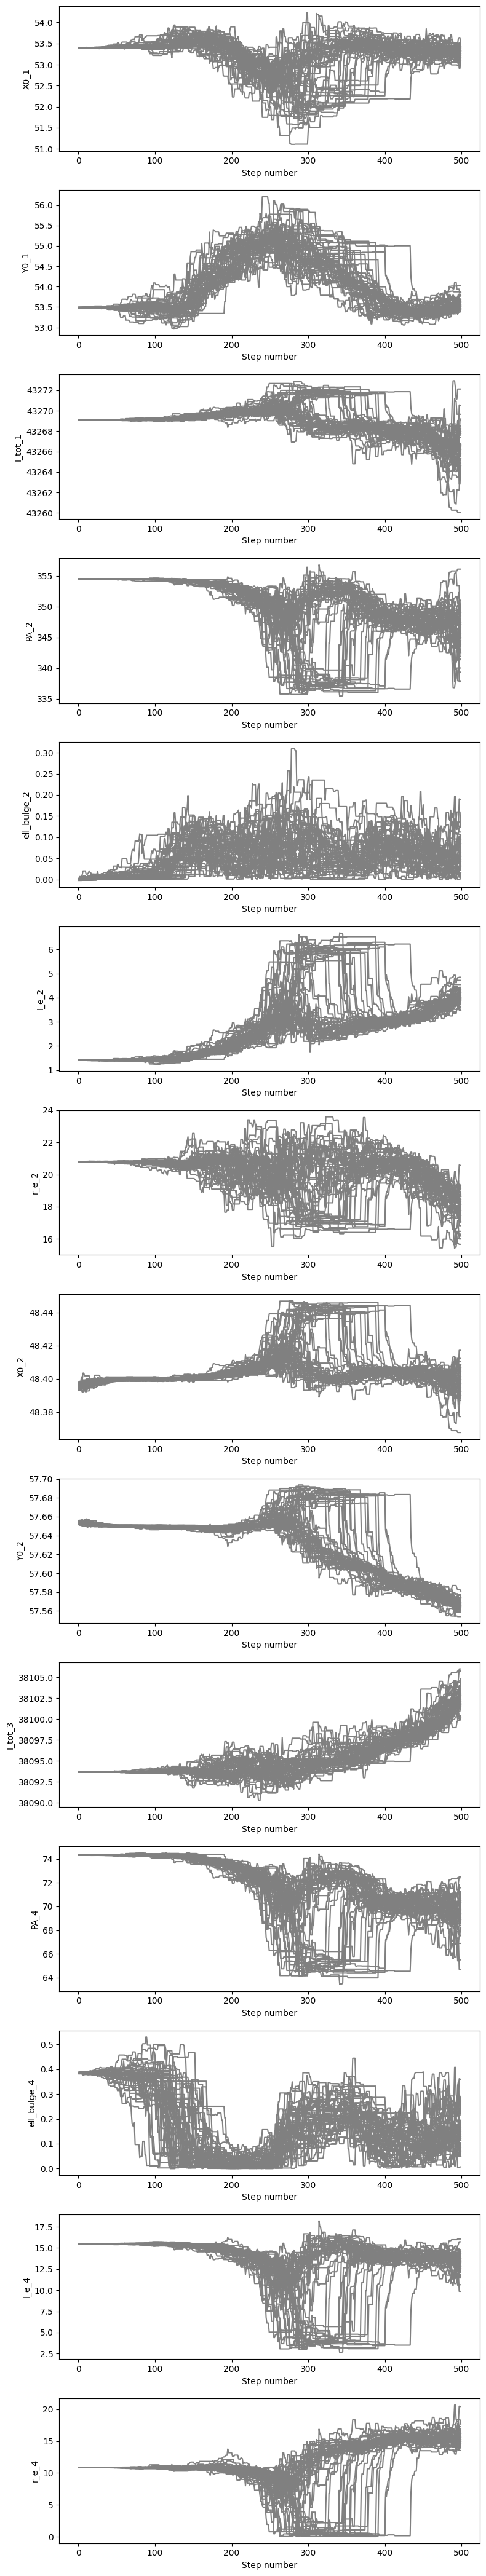

In [147]:
with open("chain_n1_1_500_pf.pkl", "rb") as file:
    d = pickle.load(file)
PlotAllWalkers(d['chain'], l, "")

In [251]:
attributes_and_methods = {}
atts = ['acceptance_fraction','chain','flatchain', 'flatlnprobability', 'lnprobability']

for attr in atts:
    # Exclude callable attributes if they have special conditions
    if attr not in ['acor', 'get_autocorr_time', 'run_mcmc', 'sample']:
        attributes_and_methods[attr] = getattr(sampler, attr)
        
attributes_and_methods

{'acceptance_fraction': array([0.37 , 0.37 , 0.334, 0.356, 0.312, 0.336, 0.314, 0.294, 0.352,
        0.334, 0.298, 0.302, 0.33 , 0.316, 0.352, 0.312, 0.318, 0.348,
        0.324, 0.31 , 0.342, 0.332, 0.32 , 0.318, 0.346, 0.348, 0.396,
        0.314, 0.308, 0.302, 0.314, 0.388, 0.32 , 0.332, 0.296, 0.33 ,
        0.304, 0.31 , 0.332, 0.378, 0.378, 0.342, 0.378, 0.324, 0.348,
        0.28 , 0.336, 0.31 , 0.346, 0.298]),
 'chain': array([[[5.33990037e+01, 5.34906840e+01, 4.32690698e+04, ...,
          3.84241398e-01, 1.54891801e+01, 1.08699234e+01],
         [5.33990037e+01, 5.34906840e+01, 4.32690698e+04, ...,
          3.84241398e-01, 1.54891801e+01, 1.08699234e+01],
         [5.33990037e+01, 5.34906840e+01, 4.32690698e+04, ...,
          3.84241398e-01, 1.54891801e+01, 1.08699234e+01],
         ...,
         [5.33834022e+01, 5.34306109e+01, 4.32659859e+04, ...,
          5.34914708e-02, 1.23687455e+01, 1.40694597e+01],
         [5.33817238e+01, 5.34313509e+01, 4.32659900e+04, ...,
   

In [253]:
with open("chain_n1_1_500_pf.pkl", 'wb') as file:
    pickle.dump(attributes_and_methods, file)

In [254]:
with open("chain_n1_1_500_pf.pkl", 'rb') as file:
    c = pickle.load(file)

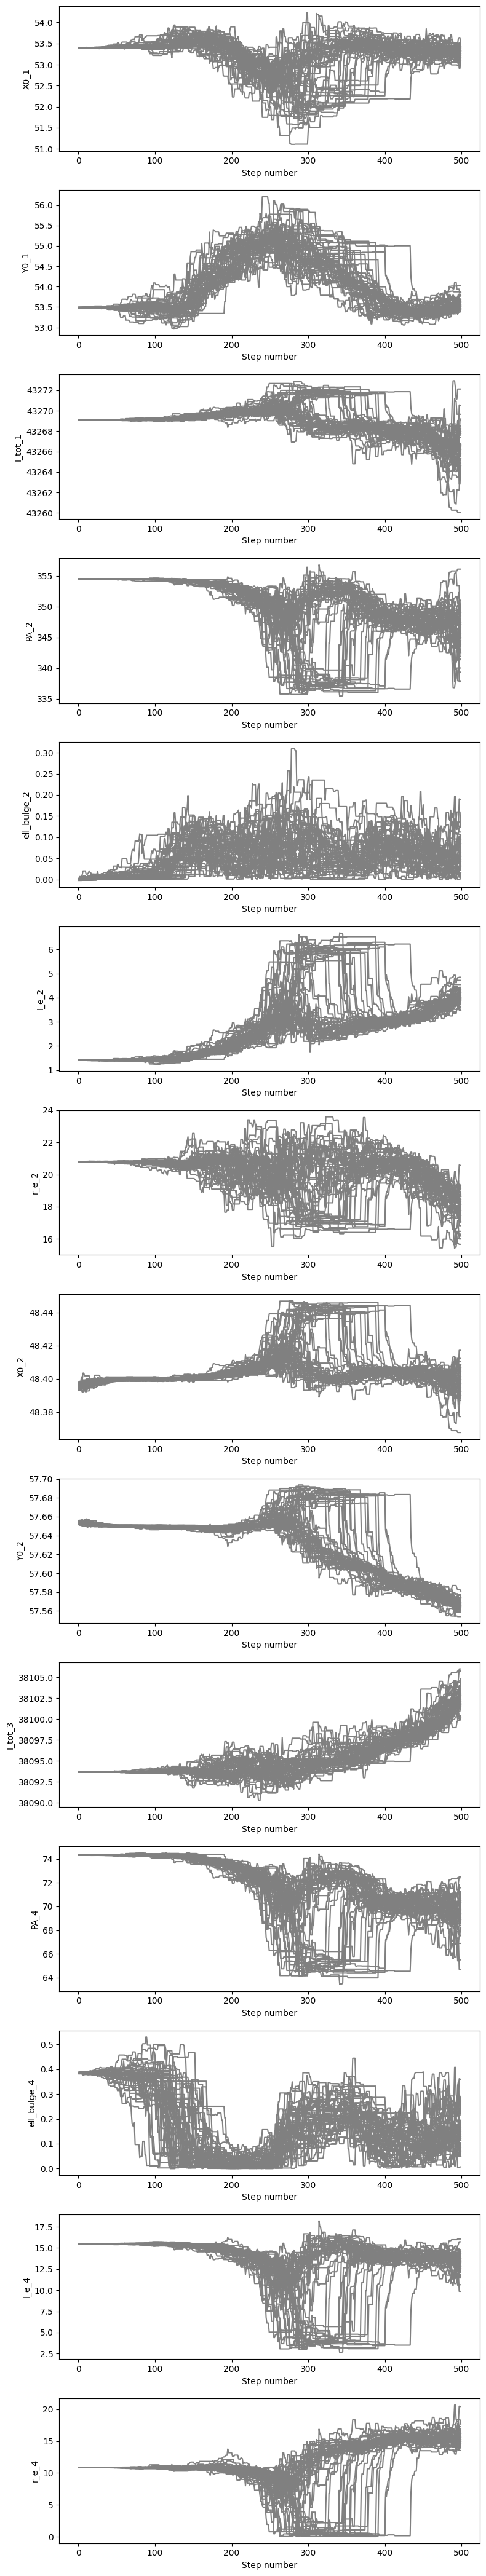

In [255]:
PlotAllWalkers(c['chain'], l, "") 